# Data-driven solution of Allen-Cahn equation

Final Version (discrete time inference) 

In [1]:
"""
@author: Yao Huang
"""

'\n@author: Yao Huang\n'

In [68]:
import torch 
import torch.nn as nn

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyDOE import lhs
import argparse
import scipy.io

In [70]:
class ACNet(nn.Module):
    def __init__(self,q,dt):
        self.layers = [1, 200, 200, 200, 200, q+1]
        super(ACNet,self).__init__()
        last_layer = nn.Linear(self.layers[-2], self.layers[-1])
        self.net =\
            [nn.Sequential(nn.Linear(input_, output_), nn.Tanh())
             for input_, output_ in 
             zip(self.layers[:-1], self.layers[1:-1])] +\
            [nn.Sequential(last_layer)]
        self.net = nn.Sequential(*self.net)
        tmp = np.float32(np.loadtxt('Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]
        self.dt = dt
        self.lb = -1.0
        self.ub = 1.0
        self.optimAdam = torch.optim.Adam(pn.parameters())
        self.optimLBFGS =\
        torch.optim.LBFGS(self.parameters(), 
                          max_iter=10000, 
                          tolerance_grad = 1.0 * np.finfo(float).eps)
    def forward(self, x):
        H = 2.0*(x - self.lb)/(self.ub - self.lb) - 1.0
        x = self.net(H)
        return x

    # loss function
    def MSE(self,ypred,ytrue):
        return torch.sum((ypred - ytrue)**2) 

    # Glorot initialization of weight matrix
    def glorot_init_mat(self,shape):
        din = shape[0]
        dout = shape[1]
        var = torch.tensor([2.0/(din+dout)])
        std = torch.sqrt(var)
        mean = torch.tensor([0.0])
        dist = torch.distributions.normal.Normal(mean, std)
        return dist.sample(shape)
    def init_weight(self, layers):        
        num_layers = len(layers) 
        for l in range(num_layers-1):
            [W, b] = list(self.net[l][0].parameters())
            W = self.glorot_init_mat(W.shape)
            b.data.fill_(0)  
            
    def U_ic(self, x0):
        xc = x0.clone()
        xc.requires_grad = True
        U = self.forward(xc)
        Uc = U[:,:-1]
        I1 = torch.ones_like(Uc)
        I1.requires_grad = True
        Uc1 = torch.autograd.grad(Uc, xc, grad_outputs=I1, create_graph=True)[0]
        Ucx = torch.autograd.grad(Uc1.sum(), I1, create_graph=True)[0]
        I2 = torch.ones_like(Ucx)
        I2.requires_grad = True
        Uc2 = torch.autograd.grad(Ucx, xc, grad_outputs=I2, create_graph=True)[0]
        Ucxx = torch.autograd.grad(Uc2.sum() , I2, create_graph=True)[0]
        F = -0.0001*Ucxx + 5*Uc**3 - 5*Uc
        u0_pred = U + torch.Tensor(self.dt)*F.mm(torch.tensor(self.IRK_weights).t())
        return u0_pred
    
    def U_bc(self, xb):
        xbc = xb.clone()
        xbc.requires_grad = True
        Ub = self.forward(xbc)
        I1 = torch.ones_like(Ub)
        I1.requires_grad = True
        Ub1 = torch.autograd.grad(Ub, xbc, grad_outputs=I1, create_graph=True)[0]
        Ubx = torch.autograd.grad(Ub1.sum(), I1, create_graph=True)[0]
        return Ub, Ubx
    
    def train(self, x0, xb, u0, MAX_EPOCHS):
        for epoch in range(MAX_EPOCHS):
            u0p = self.U_ic(x0)
            Ubp, Ubp1 = self.U_bc(xb)
            loss = self.MSE(u0p, u0.expand(u0p.shape))+\
            self.MSE(Ubp[0:1,:], Ubp[1:2,:])+ self.MSE(Ubp1[0:1,:], Ubp1[1:2,:])
            self.optimAdam.zero_grad()
            loss.backward()
            self.optimAdam.step()
        runloss=self._train_LBFGS(x0, xb, u0)
        return runloss
    
    def _train_LBFGS(self, x0, xb, u0):
        def closure():   
            self.optimLBFGS.zero_grad()
            u0p = self.U_ic(x0)
            Ubp, Ubp1 = self.U_bc(xb)
            loss = self.MSE(u0p, u0.expand(u0p.shape))+\
            self.MSE(Ubp[0:1,:], Ubp[1:2,:])+ self.MSE(Ubp1[0:1,:], Ubp1[1:2,:])
            loss.backward()
            return loss
        self.optimLBFGS.step(closure)
        runloss = closure().item()
        return runloss
    def predict(self, x):
        U_pred = pn.forward(x)
        u_pred = U_pred[:,-1]
        return u_pred

In [72]:
N, q = 200,100
#Data loading
data = scipy.io.loadmat('Data/AC.mat')    
t = data['tt'].flatten()[:,None]#T x 1
x = data['x'].flatten()[:,None]# N x 1
Exact = np.real(data['uu'])#N x T
# Doman bounds
lb, ub= np.array([-1.0]), np.array([1.0])
idx_t0, idx_t1, dt = 20, 180, t[idx_t1] - t[idx_t0]
idx_x = np.random.choice(Exact.shape[0], N, replace=False) 
x0 = torch.tensor(x[idx_x,:].reshape((-1, 1))).type(torch.FloatTensor)
u0 = torch.tensor(Exact[idx_x, idx_t0:idx_t0+1].reshape((-1, 1))).type(torch.FloatTensor)
#u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])
# Boudanry data
xb = torch.tensor(np.vstack((lb,ub)).reshape((-1, 1))).type(torch.FloatTensor)
x_star = torch.tensor(x).type(torch.FloatTensor)
u_star = Exact[:, idx_t1:idx_t1+1]

In [73]:
"""training process"""
#Instantiate class
pn = ACNet(q,dt)
#Initialize weights
pn.init_weight(pn.layers)
#Training
runloss=pn.train( x0, xb, u0, MAX_EPOCHS=10000)

In [ ]:
u_pred = pn.predict(x_star)
error = np.linalg.norm(u_pred.detach().numpy() -u_star.reshape(-1), 2)/\
np.linalg.norm(u_star.reshape(-1), 2)
print('Error: %e' % (error))

In [201]:
#save trained model
fname = "ACNet_{}.pt".format(MAX_EPOCHS)
torch.save(pn, fname)

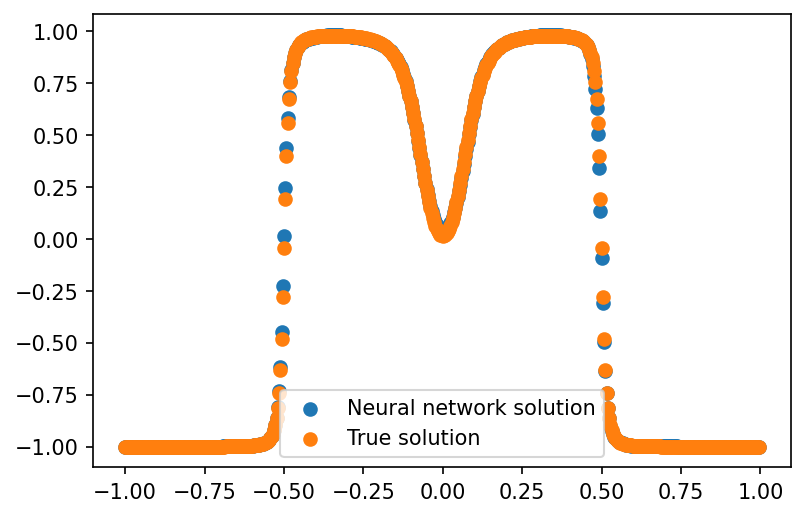

In [20]:
#%%
plt.figure(dpi=150)
plt.scatter(x_star.data.numpy(), u_pred.data.numpy(), label="Neural network solution")
plt.scatter(x_star.data.numpy(), u_star, label="True solution")
plt.legend()
plt.savefig("PINN_soln_comp_{}.png".format(MAX_EPOCHS))
#plt.show()

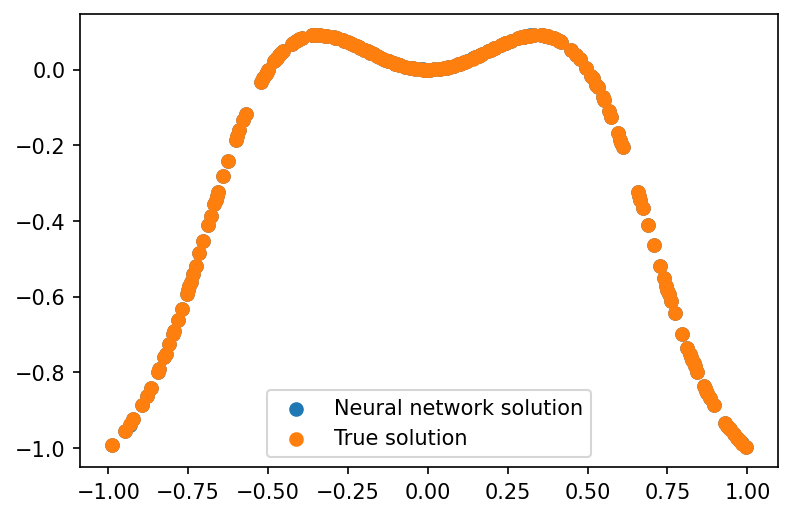

In [208]:
#%%
plt.figure(dpi=150)

plt.scatter(x0.data.numpy(), u0_pred[:,0:1].data.numpy(), label="Neural network solution")
plt.scatter(x0.data.numpy(), u0, label="True solution")
plt.legend()
#plt.savefig("PINN_soln_comp_{}.png".format(N_f))
#plt.show()